In [1]:
%cd /content/drive/MyDrive/MCUT/R911R912
!ls

/content/drive/MyDrive/MCUT/R911R912
20220413		code	     test.csv
ARO1_pearsonr_corr.csv	data	     Untitled0.ipynb
ARO1特徵因子分析.ipynb	dataset.pkl  Untitled1.ipynb
ARO2_pearsonr_corr.csv	model
ARO2特徵因子分析.ipynb	PPT


In [2]:
!pip install pytorch_lightning

     |████████████████████████████████| 582 kB 4.1 MB/s 
     |████████████████████████████████| 398 kB 45.0 MB/s 
     |████████████████████████████████| 136 kB 54.3 MB/s 
     |████████████████████████████████| 596 kB 40.0 MB/s 
     |████████████████████████████████| 1.1 MB 28.0 MB/s 
     |████████████████████████████████| 144 kB 38.5 MB/s 
     |████████████████████████████████| 271 kB 38.3 MB/s 
     |████████████████████████████████| 94 kB 2.7 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow

In [3]:
import torch
import torch.nn as nn
import numpy as np
from torch.optim import Adam
import pandas as pd
from torch.utils.data import TensorDataset,DataLoader
import joblib
import requests
from tqdm import tqdm_notebook as tqdm
from pytorch_lightning import seed_everything
import random
import warnings 
import matplotlib.pyplot as plt
import seaborn as sns
import os
warnings.filterwarnings('ignore')
exec(requests.get('https://raw.githubusercontent.com/facebookresearch/madgrad/main/madgrad/madgrad.py').text)

def set_seed(seed = int):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    seed_everything(seed)
    return random_state
random_state = set_seed(42)

Global seed set to 42


In [7]:
# Load data
data = joblib.load('20220413/dataset.pkl')
data['state'].shape,data['action'].shape,data['value'].shape

((6778, 8, 13), (6778, 8, 6), (6778, 1))

In [8]:
batch_size = 32
hidden_size = 128
state_size = data['state'].shape[2]
request_size = data['value'].shape[1]
value_size = data['value'].shape[1]
action_size = data['action'].shape[2]
time_step = data['state'].shape[1]

,0
count,6778.000000
mean,0.782184
std,0.165128
min,0.000000
25%,0.745402
50%,0.804199
75%,0.883572
max,0.986348


,0
count,6778.000000
mean,0.894664
std,0.052709
min,0.804201
25%,0.848925
50%,0.894799
75%,0.940357
max,0.986297


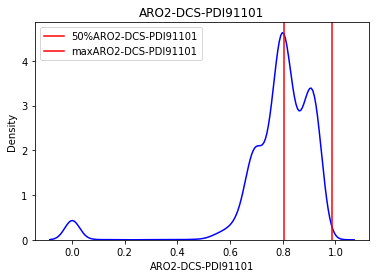

(6778, 8, 13)
(6778, 8, 6)
(6778, 1)
(6778, 1)


In [9]:
a = pd.DataFrame(data['value']).describe()
display(a)

data['request'] = None

for i in a.columns:
    if data['request'] == None:
        data['request'] = np.random.uniform(low=a.loc['50%'][i],high=a.loc['max'][i],size=(data['value'].shape[0],1))
    else:
        data['request'] = np.hstack([data['request'],np.random.uniform(low=a.loc['50%'][i],high=a.loc['max'][i],size=(data['value'].shape[0],1))])

b = pd.DataFrame(data['request']).describe()
display(b)

a = pd.DataFrame(data['value'],columns=data['value_col'])
for i in a.columns:
    sns.kdeplot(a[i],color='b')
    plt.axvline(x=a.describe().loc['50%',i], label= "50%"+str(i), c='r')
    plt.axvline(x=a.describe().loc['max',i], label= "max"+str(i), c='r')
    plt.legend()
    plt.title(i)
    plt.show()

# shape
print(data['state'].shape)
print(data['action'].shape)
print(data['value'].shape)
print(data['request'].shape)

# tensor
data['state'] = torch.FloatTensor(data['state'])
data['request'] = torch.FloatTensor(data['request'])
data['action'] = torch.FloatTensor(data['action'])
data['value'] = torch.FloatTensor(data['value'])



# data_iter
data = TensorDataset(data['state'],data['request'],data['action'],data['value'])
train_iter = DataLoader(data,batch_size=batch_size,shuffle=True)

In [10]:
class R2D2(nn.Module):
  def __init__(self,obs_size,n_actions,hidden_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.l1 = nn.Linear(obs_size,self.hidden_size)
    self.l2 = nn.LSTMCell(self.hidden_size,self.hidden_size)
    self.l3 = nn.Linear(self.hidden_size,n_actions)
  
  def forward(self,x,hx,cx):
    x = torch.tanh(self.l1(x))
    hx,cx = self.l2(x,(hx,cx))
    x = torch.tanh(hx)
    x = torch.sigmoid(self.l3(x)) # to range[0,1]
    return x,hx,cx

In [11]:
class ActorCritic(nn.Module):
  def __init__(self,actor,critic,time_step):
    super().__init__()
    self.time_step = time_step
    
    self.actor = actor
    self.actor_optimizer = MADGRAD(actor.parameters() ,lr = 1e-3)
    
    self.critic = critic
    self.critic_optimizer = MADGRAD(critic.parameters() ,lr = 1e-3)
  
  def forward(self,state,request):
    actions = self.actor_forward(state,request)
    values = self.critic_forward(state,actions)
    return values

  def actor_forward(self,state,request,eval=False):
    '''
    # 給定狀態(不可控)和需求 輸出一系列動作
    '''
    # train or eval model
    if eval == True:
      self.actor.eval()
    else:
      self.actor.train()
    
    # initialize hx,cx
    hx = torch.zeros((state.size()[0],actor.hidden_size))
    cx = torch.zeros((state.size()[0],actor.hidden_size))
    
    # get actions shape(batch_size,time_step,action_size)
    actions = torch.FloatTensor()
    
    # 對一定時間長度進行遍歷
    for t in range(self.time_step):
      # 在t時刻 根據t時刻的狀態,需求以及短期記憶hx,長期記憶cx當作輸入,得到輸出a(動作),更新後的短期記憶hx,更新後的長期記憶cx
      a,hx,cx = self.actor(torch.cat((state[:,t,:],request),dim=1),hx,cx)
      actions = torch.cat((actions,a),dim=1)
    # 一系列動作 (Batch,Time,Features)
    actions = actions.reshape(state.size()[0],self.time_step,-1)
    
    return actions
  
  def critic_forward(self,state,action,eval=False):
    '''
    # 輸入狀態(不可控)和一系列動作(可控),預測產出
    '''

    # train or eval model
    if eval == True:
      self.critic.eval()
    else:
      self.critic.train()
    
    # initialize hx,cx
    hx = torch.zeros((state.size()[0],critic.hidden_size))
    cx = torch.zeros((state.size()[0],critic.hidden_size))

    # get values shape(batch_size,time_step,value_size)
    values = torch.FloatTensor()
    
    # 對時間點遍歷
    for t in range(self.time_step):
      # 根據當前t時刻狀態,動作,hx,cx當輸入得到,v(產出),更新hx,cx
      v,hx,cx = self.critic(torch.cat((state[:,t,:],action[:,t,:]),dim=1),hx,cx)
      values = torch.cat((values,v),dim=1)
    
    # 一系列產出(Batch,Time,Features)
    values = values.reshape(state.size()[0],self.time_step,-1)
    
    # 只取最後一個時間點
    return values[:,-1,:] # return last time_step

  def train_critic(self,state,action,value):
    '''
    x: [state,action]
    y: [value]
    '監督式學習'
    '''
    self.critic.train()
    self.actor.eval()
    value_hat = self.critic_forward(state,action)
    
    # 預測值跟label的平方差愈小愈好
    loss = ((value_hat-value)**2).mean()
    loss.backward()
    self.critic_optimizer.step()
    self.critic_optimizer.zero_grad()
    return loss.item()
  
  def train_actor(self,state,request):
    '''
    x: [state,request]
    y: maximum critic value
    '最小化產出跟request的差異'
    '''
    self.actor.train()
    self.critic.eval()
    actions = self.actor_forward(state,request)
    value_hat = self.critic_forward(state,actions)

    # 首先預測值跟需求的平方差愈小愈好
    loss1 = ((request-value_hat)**2).mean()

    # 再來避免"變異數太大(時間維度上)" 因為盤控人員不可能突然調太多
    loss2 = actions.reshape(-1,time_step,action_size).std(axis=1)
    loss2 = loss2.sum(axis=-1).mean(axis=0)

    loss = loss1 + loss2
    loss.backward()
    
    self.actor_optimizer.step()
    self.actor.zero_grad()

    return loss.item()

In [12]:
actor = R2D2(state_size+request_size,action_size,hidden_size)
critic = R2D2(state_size+action_size,value_size,hidden_size)
model = ActorCritic(actor,critic,time_step)

In [13]:
def train_critic():
  loss = 0
  for i,(bs,br,ba,bv) in enumerate(train_iter):
    loss += model.train_critic(bs,ba,bv)
  return loss

def train_actor():
  loss = 0
  for i,(bs,br,ba,bv) in enumerate(train_iter):
    loss += model.train_actor(bs,br)
  return loss

def train(model,train_iter,epochs=100):
  train_history = {}
  train_history['actor'] = []
  train_history['critic'] = []
  
  for epoch in tqdm(range(epochs)):
    loss = train_critic()
    train_history['critic'].append(loss)
    if epoch % 10 == 0:
      print('epoch:{} critic_loss:{}'.format(epoch,loss))
    
  for epoch in tqdm(range(epochs)):
    loss = train_actor()
    train_history['actor'].append(loss)
    if epoch % 10 == 0:
      print('epoch:{} actor_loss:{}'.format(epoch,loss))
    
  return model,train_history

In [14]:
s,r,a,v = next(iter(train_iter))
actions = model.actor_forward(s,r,eval=True)
print(actions.shape)
pd.DataFrame(actions[0].detach().numpy()).head().style.background_gradient()

torch.Size([32, 8, 6])


,0,1,2,3,4,5
0,0.490379,0.482514,0.523308,0.483512,0.479737,0.513453
1,0.486332,0.480202,0.523805,0.485435,0.477098,0.515890
2,0.483774,0.478839,0.523942,0.486911,0.476150,0.517009
3,0.482195,0.478090,0.523981,0.487912,0.475910,0.517430
4,0.481223,0.477702,0.524005,0.488547,0.475934,0.517516


In [15]:
model,train_history = train(model,train_iter,epochs=42)

  0%|          | 0/42 [00:00<?, ?it/s]

epoch:0 critic_loss:2.7680168494116515
epoch:10 critic_loss:0.523336268030107
epoch:20 critic_loss:0.463055549422279
epoch:30 critic_loss:0.33196949283592403
epoch:40 critic_loss:0.23546715323755052


  0%|          | 0/42 [00:00<?, ?it/s]

epoch:0 actor_loss:5.8942015916109085
epoch:10 actor_loss:2.8643455589190125
epoch:20 actor_loss:2.6937154119368643
epoch:30 actor_loss:2.687600272009149
epoch:40 actor_loss:2.68374382564798


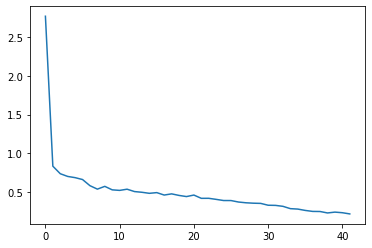

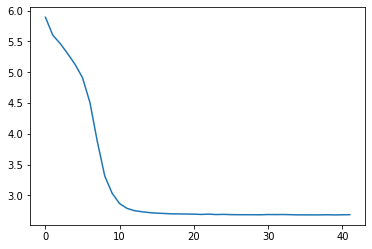

In [16]:
import matplotlib.pyplot as plt

plt.plot(train_history['critic'])
plt.show()
plt.plot(train_history['actor'])

In [17]:
s,r,a,v = next(iter(train_iter))
actions = model.actor_forward(s,r,eval=True)

In [18]:
values = model.critic_forward(s[[0]],actions[[0]],eval=True)
values

tensor([[0.8599]], grad_fn=<SliceBackward0>)

In [19]:
wanna_ouput = [1.0]
print(wanna_ouput)
s,r,a,v = next(iter(train_iter))
s = s[0].reshape(-1,time_step,state_size)
r = torch.full((1,1),wanna_ouput[0])
a = model.actor_forward(s,r,eval=True)
v = model.critic_forward(s,a,eval=True)

[1.0]


In [20]:
values_list = []
for i in tqdm(range(365)):
    s,r,a,v = next(iter(train_iter))
    s = s[0].reshape(-1,time_step,state_size)
    r = torch.full((1,1),wanna_ouput[0])
    a = model.actor_forward(s,r,eval=True)# 模型建議操作
    v = model.critic_forward(s,a,eval=True)
    values_list.append(v.detach().numpy()[0])
values_list = np.array(values_list)

  0%|          | 0/365 [00:00<?, ?it/s]

In [21]:
values_list.min(),values_list.mean(),values_list.max()

(0.35632, 0.8430517, 0.9121412)

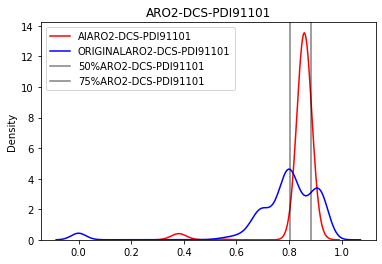

In [22]:
data = joblib.load('20220413/dataset.pkl')
a = pd.DataFrame(data['value'],columns=data['value_col'])

for i,c in enumerate(a.columns):
    sns.kdeplot(values_list[:,i],label='AI'+str(c),color='r')
    sns.kdeplot(data['value'][:,i],label='ORIGINAL'+str(c),color='b')
    plt.axvline(x=a.describe().loc['50%',c], label= "50%"+c, c='k',alpha=0.5)
    plt.axvline(x=a.describe().loc['75%',c], label= "75%"+c, c='k',alpha=0.5)
    plt.legend()
    plt.title(c)
    plt.show()

In [23]:
# save weight
torch.save(model.actor.state_dict(),'20220413/actor.pth')
torch.save(model.critic.state_dict(),'20220413/critic.pth')